In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch
import torch.nn as nn

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding=kernel_size//2, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=7):
        super(MobileNetV2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(32, 64, 3, 1),
            DepthwiseSeparableConv(64, 128, 3, 2),
            DepthwiseSeparableConv(128, 128, 3, 1),
            DepthwiseSeparableConv(128, 256, 3, 2),
            DepthwiseSeparableConv(256, 256, 3, 1),

            DepthwiseSeparableConv(256, 512, 3, 2),
            DepthwiseSeparableConv(512, 512, 3, 1),
            DepthwiseSeparableConv(512, 512, 3, 1),
            DepthwiseSeparableConv(512, 512, 3, 1),

            DepthwiseSeparableConv(512, 512, 3, 1),
            DepthwiseSeparableConv(512, 1024, 3, 2),
            DepthwiseSeparableConv(1024, 1024, 3, 1),

            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2(num_classes=7).to(device)
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
    transforms.ToTensor(),
])


valid_transform = transforms.Compose([
    transforms.ToTensor(),
])


root_dir = '/kaggle/input/fer2013'
train_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=train_transform)
valid_dataset = datasets.ImageFolder(root=root_dir + '/train', transform=valid_transform)
test_dataset = datasets.ImageFolder(root=root_dir + '/test', transform=valid_transform)


train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])


trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
validloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min', verbose=True)

num_epochs = 100
trl, tra, tel, tea = [], [], [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        train_loss += loss.item()
        _, predicted_train = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted_train.eq(labels).sum().item()


    train_accuracy = correct_train / total_train
    tra.append(train_accuracy)
    train_loss /= len(trainloader)
    trl.append(train_loss)


    model.eval()
    with torch.no_grad():
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted_valid = outputs.max(1)
            total_valid += labels.size(0)
            correct_valid += predicted_valid.eq(labels).sum().item()


        valid_accuracy = correct_valid / total_valid
        tea.append(valid_accuracy)
        valid_loss /= len(validloader)
        tel.append(valid_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, '
              f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {100 * valid_accuracy:.2f}%')


        scheduler.step(valid_loss)


model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted_test = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_accuracy = correct_test / total_test
test_loss /= len(testloader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [1/100], Train Loss: 1.7584, Train Accuracy: 28.13%, Validation Loss: 1.7288, Validation Accuracy: 32.04%
Epoch [2/100], Train Loss: 1.6255, Train Accuracy: 35.73%, Validation Loss: 1.5972, Validation Accuracy: 37.72%
Epoch [3/100], Train Loss: 1.5418, Train Accuracy: 40.24%, Validation Loss: 1.5735, Validation Accuracy: 38.17%
Epoch [4/100], Train Loss: 1.4845, Train Accuracy: 42.97%, Validation Loss: 1.4693, Validation Accuracy: 42.55%
Epoch [5/100], Train Loss: 1.4401, Train Accuracy: 44.70%, Validation Loss: 1.4330, Validation Accuracy: 44.53%
Epoch [6/100], Train Loss: 1.4083, Train Accuracy: 46.28%, Validation Loss: 1.3640, Validation Accuracy: 46.66%
Epoch [7/100], Train Loss: 1.3747, Train Accuracy: 47.18%, Validation Loss: 1.3881, Validation Accuracy: 46.45%
Epoch [8/100], Train Loss: 1.3415, Train Accuracy: 49.06%, Validation Loss: 1.3878, Validation Accuracy: 45.92%
Epoch [9/100], Train Loss: 1.3091, Train Accuracy: 50.10%, Validation Loss: 1.3355, Validation Accuracy:

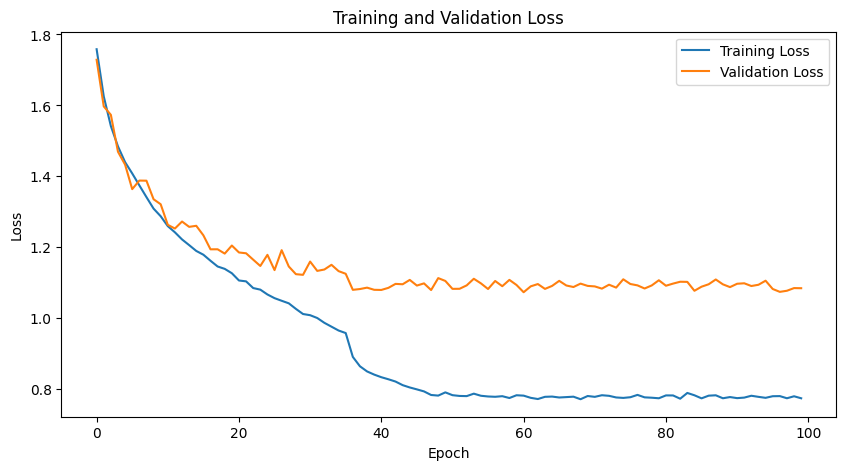

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(trl, label='Training Loss')
plt.plot(tel, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


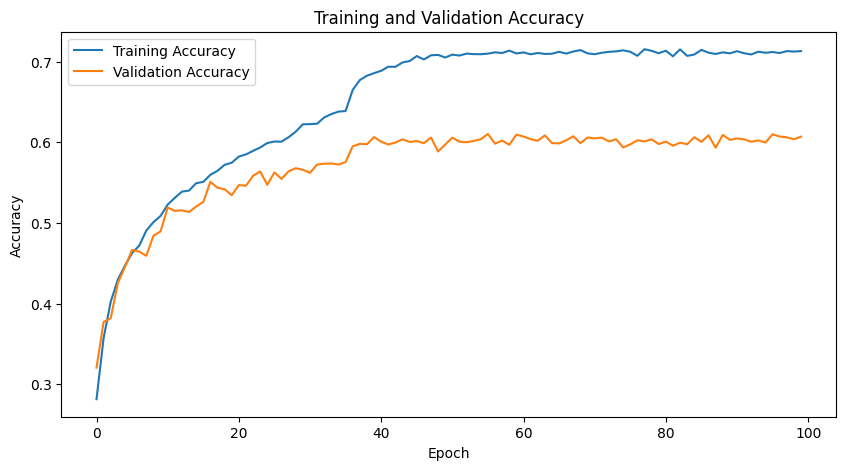

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tra, label='Training Accuracy')
plt.plot(tea, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Correctly Predicted Images:


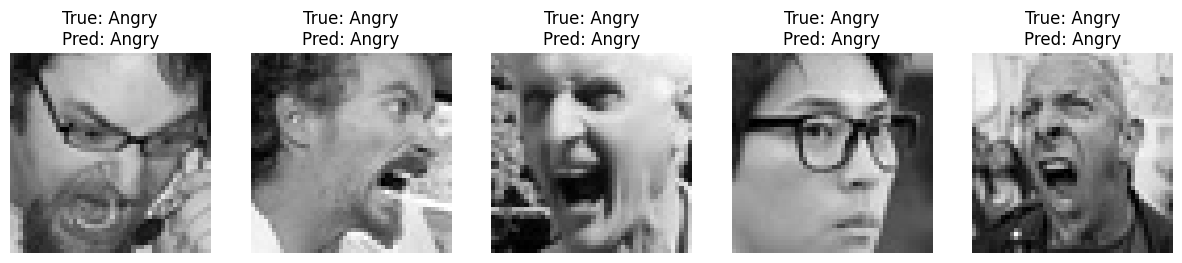

Incorrectly Predicted Images:


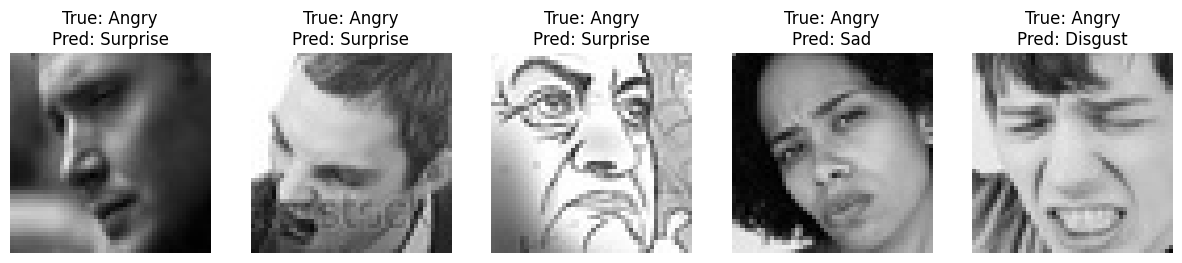

In [ ]:

model.eval()
class_names = {0: 'Angry',1: 'Disgust',2: 'Fear',3: 'Happy',4: 'Sad',5: 'Surprise',6: 'Neutral'}

model.eval()
correct = 0
total = 0
correct_images_info = []
incorrect_images_info = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct_mask = predicted.eq(labels)
        incorrect_mask = ~correct_mask

        correct_images = inputs[correct_mask]
        correct_labels = labels[correct_mask]
        correct_predictions = predicted[correct_mask]

        incorrect_images = inputs[incorrect_mask]
        incorrect_labels = labels[incorrect_mask]
        incorrect_predictions = predicted[incorrect_mask]

        # Store information about correctly predicted images
        for i in range(len(correct_images)):
            correct_images_info.append({
                'image': correct_images[i].cpu().numpy(),
                'true_label': correct_labels[i].item(),
                'predicted_label': correct_predictions[i].item()
            })

        # Store information about incorrectly predicted images
        for i in range(len(incorrect_images)):
            incorrect_images_info.append({
                'image': incorrect_images[i].cpu().numpy(),
                'true_label': incorrect_labels[i].item(),
                'predicted_label': incorrect_predictions[i].item()
            })

        break  # Only process the first batch

# Print some correctly predicted images
print("Correctly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(correct_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(correct_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[correct_images_info[i]["true_label"]]
    pred_label = class_names[correct_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()

# Print some incorrectly predicted images
print("Incorrectly Predicted Images:")
plt.figure(figsize=(15, 3))
for i in range(min(5, len(incorrect_images_info))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(incorrect_images_info[i]['image'].transpose(1, 2, 0).squeeze())
    true_label = class_names[incorrect_images_info[i]["true_label"]]
    pred_label = class_names[incorrect_images_info[i]["predicted_label"]]
    plt.title(f'True: {true_label}\nPred: {pred_label}')
    plt.axis('off')
plt.show()




In [ ]:
torch.save(model.state_dict(), 'MobileNet.pth')